<a href="https://colab.research.google.com/github/Beh-noush/General-Python/blob/main/Linear_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data

We consider data points in 2 dimensions. 

In [28]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from IPython import display
import time

In [79]:
#making training data
data, labels = make_blobs(n_samples= 2000, n_features=2, centers = [[-5,-10], [-8,-7]], random_state = 1)

#making test data
data_test, labels_test = make_blobs(n_samples= 6000, n_features=2, centers = [[-5,-10], [-8,-7]], random_state = 2)


Text(0, 0.5, 'x2')

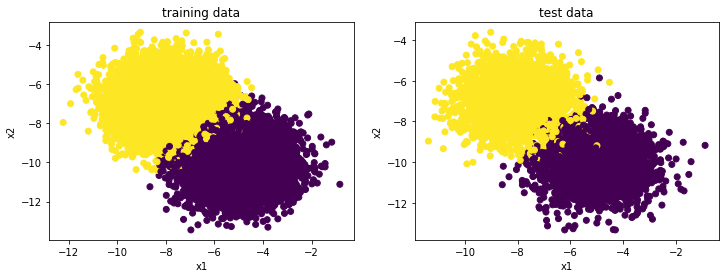

In [45]:
#plotting training and test data

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(data[:,0],data[:,1], c = labels)
plt.title('training data') 
plt.xlabel('x1')
plt.ylabel('x2')
plt.subplot(122)
plt.scatter(data_test[:,0],data_test[:,1], c = labels_test) 
plt.title('test data')
plt.xlabel('x1')
plt.ylabel('x2')

Here, we implement a one-versus-all SVM, so that we can use it for multi-class classification as well. That's why we make a suitable representation for labels, i.e., one-versus-all labelling!


In [29]:
#binary SVM
#Classifies based on the linear relation x -> sign(w.x + b). The decision hyperplane is: w.x + b = 0.
class SVM:
  def __init__(self,eta, C, niter, batch_size, verbose):
    self.eta = eta; self.C = C; self.niter = niter; self.batch_size = batch_size; self.verbose = verbose

  def make_one_versus_all_labels(self, y, m):
    """
    y : numpy array of shape (n,)
    m : int (in this homework, m will be 10)
    returns : numpy array of shape (n,m)
    """   
    array = -np.ones((len(y), m))
    for i in range(len(y)):
      array[i][int(y[i])] = 1
    return array


  def compute_loss(self, x, y):
    """
    x : numpy array of shape (minibatch size, 401)
    y : numpy array of shape (minibatch size, 2)
    returns : float
    """
    batch_size = x.shape[0] 
    #num_features = x.shape[1]

#    self.w = np.zeros([self.num_features, self.m])
    self.value = np.maximum(0, 1 - np.multiply(np.matmul(x,self.w),y))
    value = np.multiply(self.value, self.value)
    value = np.sum(value, axis = 1) #the sum goes over the classes, but not the minibatch
    hinge = self.C/batch_size *(np.sum(value))
    regularizer = .5*np.multiply( self.w, self.w).sum()
    #print(hinge)
    return regularizer + hinge

  def compute_gradient(self, x, y):
    """
    x : numpy array of shape (minibatch size, 401)
    y : numpy array of shape (minibatch size, 10)
    returns : numpy array of shape (401, 10)
    """
    self.value = np.maximum(0, 1 - np.multiply(np.matmul(x,self.w),y))
    grad_hinge = -2*np.matmul(x.T, np.multiply(y,self.value))
    grad_hinge[np.where(self.value<0)] = 0
    grad_regularizer = self.w
    gradient = self.C/self.batch_size *grad_hinge + grad_regularizer
   # print(f'\ngradient = {gradient}')
    return gradient
    #return grad_regularizer+grad_hinge if grad_hinge

  # Batcher function
  def minibatch(self, iterable1, iterable2, size=1):
    l = len(iterable1)
    n = size
    for ndx in range(0, l, n):
      index2 = min(ndx + n, l)
      yield iterable1[ndx: index2], iterable2[ndx: index2]

  def infer(self, x):
    """
    x : numpy array of shape (number of examples to infer, 401)
    returns : numpy array of shape (number of examples to infer, 10)
    """
    inner_prod = np.matmul(x,self.w)
   # print(inner_prod[:5])
    y = np.argmax(inner_prod,axis =1)
    return self.make_one_versus_all_labels(y,self.m)

  def compute_accuracy(self, y_inferred, y):
    """
    y_inferred : numpy array of shape (number of examples, 10)
    y : numpy array of shape (number of examples, 10)
    returns : float
    """
    mult = np.multiply(y_inferred,y)
    summ = np.sum(mult, axis = 1)
    acc = np.mean(summ == self.m)
    return acc
   # np.mean(y_inferred[:] == y[:])

  def fit(self, x_train, y_train, x_test, y_test):
    """
    x_train : numpy array of shape (number of training examples, 401)
    y_train : numpy array of shape (number of training examples, 10)
    x_test : numpy array of shape (number of training examples, 401)
    y_test : numpy array of shape (number of training examples, 10)
    returns : float, float, float, float
    """
    x_min,x_max =  x_train[:,0].min(), x_train[:,0].max()
    
    self.num_features = x_train.shape[1]
    self.m = int(y_train.max()) + 1
    y_train = self.make_one_versus_all_labels(y_train, self.m)
    y_test = self.make_one_versus_all_labels(y_test, self.m)
    self.w = np.zeros([self.num_features, self.m]) #For now, our classifier does not have the bias term. 
    list_train_loss =[]
    list_test_loss =[]
    list_train_acc =[]
    list_test_acc =[]
    for iteration in range(self.niter):
      # Train one pass through the training set
      for x, y in self.minibatch(x_train, y_train, size=self.batch_size):
       # self.minibatch_size = x.shape[0] 
        grad = self.compute_gradient(x,y)
        self.w -= self.eta * grad
      #This part of fitting is to plot the decision boundary at each epoch.
      w1,w2 = self.w[:,0]
      coeff = -w1/w2
      plt.scatter(data[:,0],data[:,1], c = labels) 
      plt.plot([x_min,x_max],[x_min*coeff,x_max*coeff])
      display.display(plt.gcf())
      display.clear_output(wait=True)
      time.sleep(.5)
      display.clear_output(wait = True) #End of plotting part
      # # Measure loss and accuracy on training set
      train_loss = self.compute_loss(x_train,y_train)
      list_train_loss.append(train_loss)
      y_inferred = self.infer(x_train)
      train_accuracy = self.compute_accuracy(y_inferred, y_train)
      list_train_acc.append(train_accuracy)
      # # Measure loss and accuracy on test set
      test_loss = self.compute_loss(x_test,y_test)
      list_test_loss.append(test_loss)
      y_inferred = self.infer(x_test)
      test_accuracy = self.compute_accuracy(y_inferred, y_test)
      list_test_acc.append(test_accuracy)
      if self.verbose:
        print("\nIteration %d:" % iteration)
        print("Train accuracy: %f" % train_accuracy)
        print("Train loss: %f" % train_loss)
        print("Test accuracy: %f" % test_accuracy)
        print("Test loss: %f" % test_loss)
        print("")

    return list_train_loss, list_train_acc, list_test_loss, list_test_acc


It took 23.00368857383728 seconds.


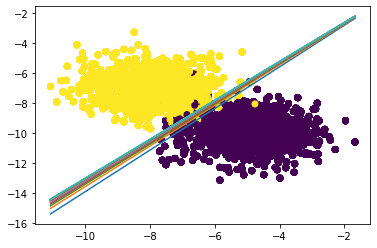

In [148]:
svm = SVM(eta=0.00001, C=500, niter=20, batch_size=100, verbose=False)
start_time = time.time()
results = svm.fit(data,labels,data_test,labels_test)
stop_time = time.time()
print(f'It took {stop_time-start_time} seconds.')
list_train_loss, list_train_acc, list_test_loss, list_test_acc = results

In [149]:
svm.w

array([[ 0.56457235, -0.56457235],
       [-0.4333861 ,  0.4333861 ]])

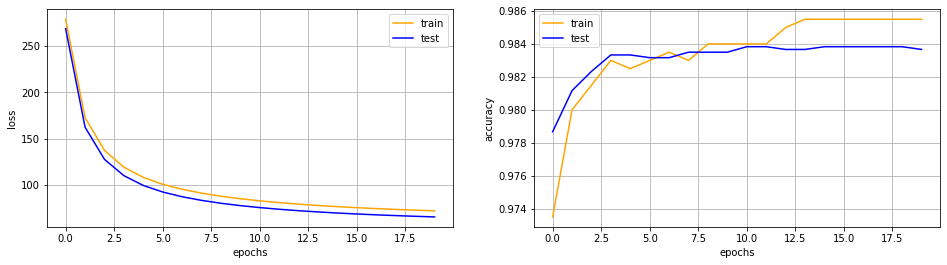

In [150]:
#plot results
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(list_train_loss, label = 'train', color = 'orange')
plt.plot(list_test_loss, label = 'test', color = 'blue')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(list_train_acc, label = 'train', color = 'orange')
plt.plot(list_test_acc, label = 'test', color = 'blue')
plt.legend()
plt.grid(True)

In [151]:
list_train_acc[-1]

0.9855

In [152]:
list_test_acc[-1]

0.9836666666666667

#SkLearn SVM

Now, we compare to SkLearn SVM.

In [153]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(LinearSVC('l2', 'hinge', C=10, tol= 1e-2, random_state= 1, max_iter = 2000, verbose=True  ))

In [154]:
clf.fit(data,labels)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('linearsvc',
                 LinearSVC(C=10, loss='hinge', max_iter=2000, random_state=1,
                           tol=0.01, verbose=True))])

In [155]:
test_pred = clf.predict(data_test)

In [156]:
(test_pred == labels_test).mean()

0.9843333333333333

In [158]:
train_pred = clf.predict(data)

In [159]:
(train_pred == labels).mean()

0.9835

In [160]:
print(clf.named_steps['linearsvc'].coef_)

[[-1.88163628  1.86385553]]


In [161]:
print(clf.named_steps['linearsvc'].intercept_)

[3.26487969]


Next step : add the bias term to the SVM classifier and compare to the Sklearn SVM result.